# Step 0: Imports

Question: 

- Do the attention heads learn to attend to the same positional encodings
- do interp -- what is it doing? can we figure out?
- update: I think we should do interp once it's bigger. 

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import sqrt
from collections import deque
import os
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 8
MAX_TUNE_VTXS = 8 # 15
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
# vertices are labelled 1,2,...,63
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list += [min(u,v),max(u,v)]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [number of vertices]+[d(1,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(n, G, target=2):
    dist = [n for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

def mkbatch(size):
    graphs1 = []
    distance1 = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS)
        edge_list, adj_list = random_graph(n)
        dist = SSSP(n, adj_list)
        edge_list[-1] = 2 # target token
        graphs1.append(edge_list)
        distance1.append(dist)
    
    data = torch.tensor(graphs1, device=device)
    labels = torch.tensor(distance1, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

def vertices_on_shortest_12_path(n, G, target=2):
    dist = [n for _ in G]
    parent = [-1 for _ in G]
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == n:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return []

def mktunebatch(size):
    graphs = []
    distance = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            path = vertices_on_shortest_12_path(n, adj_list)
            if len(path) > 1:
                target_vtx_idx = random.randrange(1, len(path))
                target_vtx = path[target_vtx_idx]
                edge_list[-1] = target_vtx
                graphs.append(edge_list)
                distance.append(target_vtx_idx)
                break
    
    data = torch.tensor(graphs, device=device)
    labels = torch.tensor(distance, dtype=torch.bfloat16, device=device)
    padding = data == PAD_TOKEN
    return data, labels, padding

In [4]:
mkbatch(5)

(tensor([[1, 2, 4, 5, 3, 4, 1, 7, 1, 2, 1, 4, 0, 0, 0, 0, 2],
         [4, 7, 5, 8, 1, 3, 6, 7, 3, 5, 4, 6, 2, 7, 0, 0, 2],
         [3, 5, 1, 3, 4, 5, 1, 4, 1, 5, 0, 0, 0, 0, 0, 0, 2],
         [3, 5, 2, 5, 2, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
         [2, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]], device='cuda:0'),
 tensor([1., 8., 5., 1., 1.], device='cuda:0', dtype=torch.bfloat16),
 tensor([[False, False, False, False, False, False, False, False, False, False,
          False, False,  True,  True,  True,  True, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False,  True,  True, False],
         [False, False, False, False, False, False, False, False, False, False,
           True,  True,  True,  True,  True,  True, False],
         [False, False, False, False, False, False, False, False,  True,  True,
           True,  True,  True,  True,  True,  True, False],
         [False, False, False, False,  Tr

(array([683.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 427.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 256.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 161.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 140.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 125.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 139.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 117.]),
 array([1.      , 1.109375, 1.21875 , 1.328125, 1.4375  , 1.546875,
        1.65625 , 1.765625, 1.875   , 1.984375, 2.09375 , 2.203125,
        2.3125  , 2.421875, 2.53125 , 2.640625, 2.75    , 2.859375,
        2.96875 , 3.078125, 3.1875  , 3.296875, 3.40625 , 3.515625,
        3.625   , 3.734375, 3.84375 , 3.953125, 4.0625  , 4.171875,
        4.28125 , 4.390625, 4.5     , 4.609375, 4.71875 , 4.828125,
        4.9375  , 5.046875, 5.15625 , 5.265625, 5.375   , 5.484375,
        5.59375 , 5.703125, 5.8125  , 5.921875, 6.03125 , 6.140625,
        6.25    , 6.35

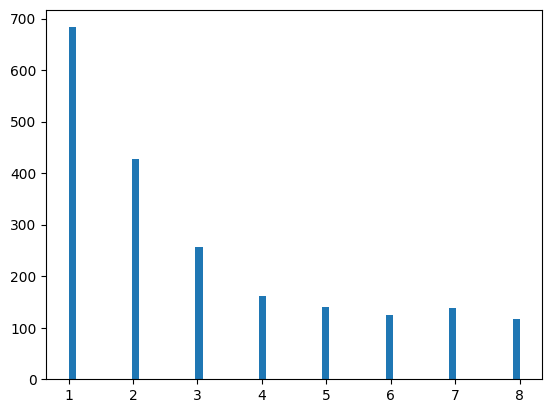

In [5]:
plt.hist(mkbatch(2048)[1].to(torch.float32).cpu(), bins=64)

(array([1.488e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.340e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.030e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.700e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.      , 1.078125, 1.15625 , 1.234375, 1.3125  , 1.390625,
        1.46875 , 1.546875, 1.625   , 1.703125, 1.78125 , 1.859375,
        1.9375  , 2.015625, 2.09375 , 2.171875, 2.25    , 2.328125,
  

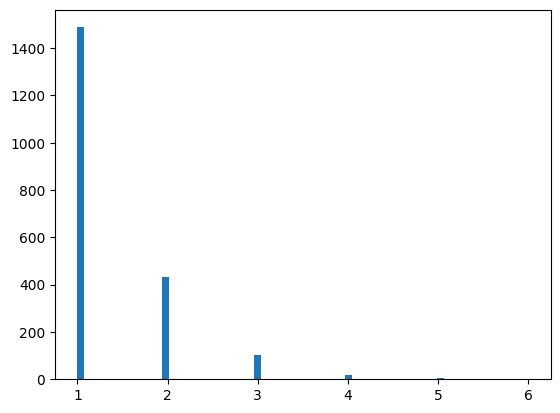

In [6]:
plt.hist(mktunebatch(2048)[1].to(torch.float32).cpu(), bins=64)

In [7]:
# import pickle

# graphs, labels, _ = mkbatch(3*10**5)

# data = {
#     "data": graphs,
#     "labels": labels
# }

# with open('data.pkl', 'wb') as file:
#     pickle.dump(data, file)

# Step 2: Define Transformer Model

In [8]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2, dtype=torch.bfloat16)
        # # seq_len is odd
        # self.fancy_encoding = torch.repeat_interleave(torch.rand((1, seq_len // 2 + 1, model_dim // 2), device=device, dtype=torch.bfloat16), 2, dim=1)
        # # cut off last element since the target vertex is not repeated
        # self.fancy_encoding = self.fancy_encoding[:, :seq_len, :]
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True, dtype=torch.bfloat16)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim, dtype=torch.bfloat16)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [14]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 1000
BSZ = 2**15 # Batch size
BPE = 16 # Batches per epoch
NHEADS = 8
NLAYERS = 16
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
# model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*BSZ*BPE//10**6}M")
print(f"Trainable parameters in the model: {trainable_params//1000}K")

train_err = []
test_err = []

# clear loss file
open('loss', 'w').close()

Training data: 524M
Trainable parameters in the model: 800K


In [27]:
LR = 2e-6
WD = 0 # 1e-5

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

In [11]:
# from torch.utils.data import DataLoader, TensorDataset

# with open("data.pkl", "rb") as f:
#     pickled_stuff = pickle.load(f)

# data = pickled_stuff["data"].to(device)
# label = pickled_stuff["labels"].to(device)
# padding_mask = (data == PAD_TOKEN).bool().to(device)
# dataset = TensorDataset(data, label, padding_mask)
# # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [.9, .1])
# train_loader = DataLoader(dataset, batch_size=BSZ, shuffle=True)

# Step 4: Train the Model for the first task

In [12]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

# figure out if it's doing better on short paths
def evaluate_short():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels==1])
    return loss.item()

In [28]:
for epoch in range(NEPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mkbatch(BSZ)
    # for batch_src, batch_labels, batch_padding_mask in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPE
        loss.backward()
        optimizer.step()

    test_loss = evaluate()
    test_short_loss = evaluate_short()
    
    test_err.append(test_loss)
    train_err.append(train_loss)
    with open('loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{NEPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}, Test short loss: {test_short_loss:.4f}")
    
    if epoch % 100 == 99:
        torch.save(model.state_dict(), f"model_weights_{epoch}.pth")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.97it/s]


Epoch 1/1000 	 Train Err: 1.1650 	 Test Err: 1.1562, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.07it/s]


Epoch 2/1000 	 Train Err: 1.1616 	 Test Err: 1.1797, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.06it/s]


Epoch 3/1000 	 Train Err: 1.1660 	 Test Err: 1.1562, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 4/1000 	 Train Err: 1.1621 	 Test Err: 1.1719, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 5/1000 	 Train Err: 1.1597 	 Test Err: 1.1562, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.00it/s]


Epoch 6/1000 	 Train Err: 1.1694 	 Test Err: 1.1406, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 7/1000 	 Train Err: 1.1660 	 Test Err: 1.1797, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 8/1000 	 Train Err: 1.1611 	 Test Err: 1.1562, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 9/1000 	 Train Err: 1.1665 	 Test Err: 1.1328, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 10/1000 	 Train Err: 1.1685 	 Test Err: 1.1797, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 11/1000 	 Train Err: 1.1582 	 Test Err: 1.1484, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 12/1000 	 Train Err: 1.1680 	 Test Err: 1.1641, Test short loss: 0.0007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 13/1000 	 Train Err: 1.1582 	 Test Err: 1.1562, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.01it/s]


Epoch 14/1000 	 Train Err: 1.1689 	 Test Err: 1.1641, Test short loss: 0.0006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.02it/s]


Epoch 15/1000 	 Train Err: 1.1670 	 Test Err: 1.1641, Test short loss: 0.0007


 31%|███████████████████████████████████████████████▌                                                                                                        | 5/16 [00:01<00:04,  2.51it/s]


KeyboardInterrupt: 

In [125]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

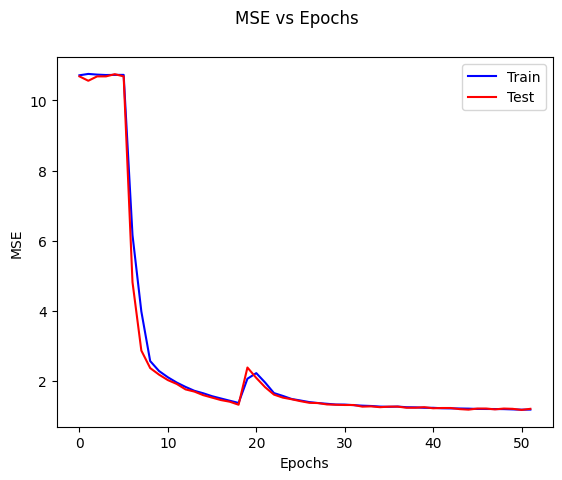

In [24]:
plt.suptitle('MSE vs Epochs')
plt.plot(train_err, label='Train', color='blue')
plt.plot(test_err, label='Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

(array([[1273.,  144.,   13., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,   16.,   21.,  197.]]),
 array([1.   , 1.14 , 1.28 , 1.42 , 1.561, 1.7  , 1.84 , 1.98 , 2.121,
        2.26 , 2.4  , 2.54 , 2.68 , 2.82 , 2.96 , 3.1  , 3.24 , 3.38 ,
        3.52 , 3.66 , 3.8  , 3.94 , 4.08 , 4.22 , 4.36 , 4.5  , 4.64 ,
        4.78 , 4.92 , 5.06 , 5.2  , 5.34 , 5.48 , 5.62 , 5.76 , 5.902,
        6.04 , 6.18 , 6.32 , 6.46 , 6.6  , 6.742, 6.88 , 7.02 , 7.16 ,
        7.3  , 7.44 , 7.582, 7.72 , 7.86 , 8.   ], dtype=float16),
 array([0.949, 1.032, 1.115, 1.198, 1.281, 1.363, 1.446, 1.529, 1.612,
        1.695, 1.778, 1.861, 1.943, 2.027, 2.11 , 2.191, 2.275, 2.36 ,
        2.441, 2.523, 2.607, 2.69 , 2.773, 2.855, 2.938, 3.021, 3.104,
        

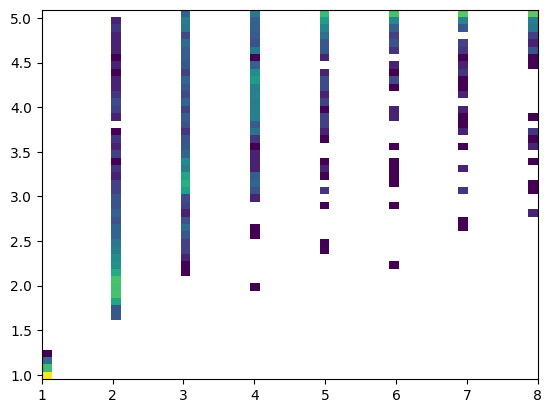

In [29]:
batch_src, batch_labels, batch_padding_mask = mkbatch(4096)
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
batch_src[0], batch_labels[0], output[0]
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 5: Fine Tune

In [24]:
N_TUNE_EPOCHS = 10
TUNE_LR = 1e-5
TUNE_WD = 0 # 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

In [27]:
def tune_evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

In [28]:
tune_train_err = []
tune_test_err = []

# clear loss file
open('tune_loss', 'w').close()

for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    for i in tqdm(range(BPE)):
        batch_src, batch_labels, batch_padding_mask = mktunebatch(BSZ)
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        train_loss += loss.item() / BPE
        loss.backward()
        optimizer.step()

    test_loss = tune_evaluate()
    
    tune_test_err.append(test_loss)
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss} {test_loss}\n")
    print(f"Epoch {epoch + 1}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f} \t Test Err: {test_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"tune_model_weights_{epoch}.pth")

100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Epoch 1/1000 	 Train Err: 0.2001 	 Test Err: 0.1592


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Epoch 2/1000 	 Train Err: 0.1355 	 Test Err: 0.1152


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 3/1000 	 Train Err: 0.1039 	 Test Err: 0.0962


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 4/1000 	 Train Err: 0.0877 	 Test Err: 0.0815


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch 5/1000 	 Train Err: 0.0775 	 Test Err: 0.0728


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch 6/1000 	 Train Err: 0.0682 	 Test Err: 0.0635


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Epoch 7/1000 	 Train Err: 0.0605 	 Test Err: 0.0581


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 8/1000 	 Train Err: 0.0548 	 Test Err: 0.0513


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 9/1000 	 Train Err: 0.0494 	 Test Err: 0.0457


100%|███████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 10/1000 	 Train Err: 0.0445 	 Test Err: 0.0403


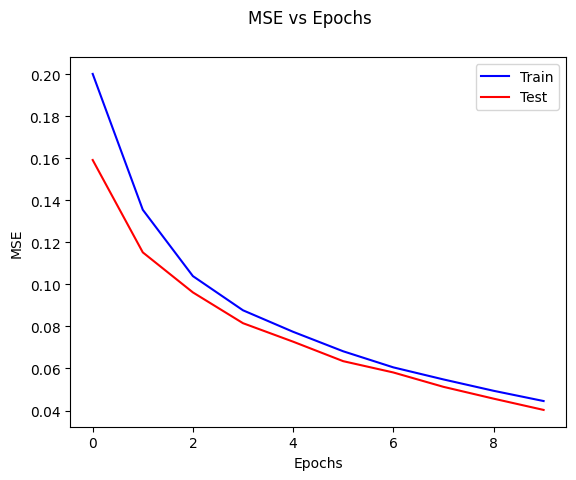

In [29]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.plot(tune_test_err, label='Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

(array([[156., 353., 404., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   4.]]),
 array([1.   , 1.06 , 1.12 , 1.18 , 1.24 , 1.3  , 1.359, 1.42 , 1.48 ,
        1.54 , 1.6  , 1.66 , 1.72 , 1.779, 1.84 , 1.9  , 1.96 , 2.02 ,
        2.08 , 2.14 , 2.2  , 2.26 , 2.32 , 2.379, 2.44 , 2.5  , 2.559,
        2.621, 2.68 , 2.74 , 2.8  , 2.86 , 2.92 , 2.98 , 3.04 , 3.1  ,
        3.16 , 3.22 , 3.28 , 3.34 , 3.4  , 3.459, 3.52 , 3.58 , 3.64 ,
        3.7  , 3.76 , 3.82 , 3.879, 3.94 , 4.   ], dtype=float16),
 array([0.879 , 0.9287, 0.9785, 1.028 , 1.078 , 1.129 , 1.179 , 1.229 ,
        1.278 , 1.328 , 1.378 , 1.428 , 1.479 , 1.527 , 1.578 , 1.628 ,
        1.678 , 1.728 , 1.777 , 1.828 , 1.877 , 1.928 , 1.978 , 2.027 ,
        2.078 , 2.127 , 2.176 , 2.227 , 2

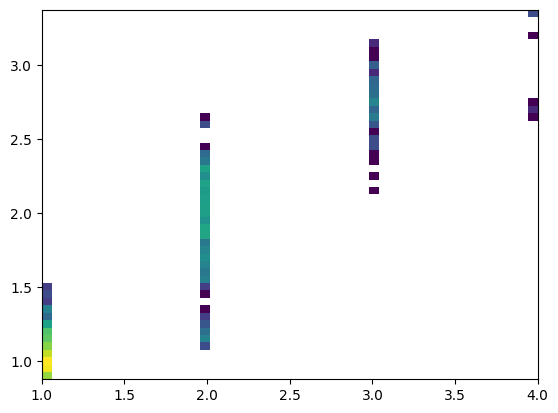

In [30]:
batch_src, batch_labels, batch_padding_mask = mktunebatch(2048)
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 6: Test generalization